# Training data processing - Cite-seq
### Chaozhong Liu

This is the notebook for pre-processing the training data.

In [1]:
#import libraries
import numpy as np
import pandas as pd

import scanpy as sc
import anndata as ad
import scipy as sp
import matplotlib.pyplot as plt



Load the data from phase1v2 common folders, you might need to change the path here.

In [2]:
adata_gex = ad.read_h5ad("data/Cite_GEX.filt.h5ad")
adata_adt = ad.read_h5ad("data/Cite_ADT.filt.h5ad")


In [3]:
print(f"The GEX data has {adata_gex.n_obs} observations and {adata_gex.n_vars} features.")
print(f"The ADT data has {adata_adt.n_obs} observations and {adata_adt.n_vars} features.")

The GEX data has 66175 observations and 13953 features.
The ADT data has 66175 observations and 134 features.


In [4]:
np.all(adata_gex.obs_names == adata_adt.obs_names)

True

### Filterging cells and features

#### Filtering GEX genes

We selected highly-variable genes, genes in ADT data and gene names starting with 'CD'.  
The gene list is saved in **data/gene_index_cite.txt**.  
Here we will just read in the gene list and select.

We didn't filter ADT features. The list is saved in **data/protein.txt**.

In [5]:
gene_index = open('data/gene_index_cite.txt','r').readlines()
gene_index = [i.strip() for i in gene_index]
gene_index = np.array(gene_index)

adata_gex = adata_gex[:,gene_index]

To filter cells, we removed cells based on **MT gene proportion**, **counts** and **number of genes expressed**. And we also removed validation batches s1d2 and s3d7.  
The cell list is saved in **data/cell_index.txt**.  
Here we will just read in the cell list and select.

In [6]:
cell_index = open('data/cell_index.txt','r').readlines()
cell_index = [i.strip() for i in cell_index]
cell_index = np.array(cell_index)

adata_gex = adata_gex[cell_index]
adata_adt = adata_adt[cell_index]

In [7]:
adata_gex

View of AnnData object with n_obs × n_vars = 44277 × 2175
    obs: 'n_genes_by_counts', 'pct_counts_mt', 'size_factors', 'phase', 'cell_type', 'pseudotime_order_GEX', 'batch', 'pseudotime_order_ADT', 'is_train'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'dataset_id', 'organism'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts'

In [8]:
adata_adt

View of AnnData object with n_obs × n_vars = 44277 × 134
    obs: 'n_antibodies_by_counts', 'total_counts', 'iso_count', 'cell_type', 'pseudotime_order_ADT', 'batch', 'pseudotime_order_GEX', 'is_train'
    var: 'feature_types'
    uns: 'dataset_id', 'organism'
    obsm: 'X_pca', 'X_umap', 'isotype_controls'
    layers: 'counts'

In [9]:
#This is the final training data for ADT, save it in data/
adata_adt.write('data/Cite_ADT.training.h5ad')
#This is not the final data for GEX, but is needed next. It will be overwritten later.
adata_adt.write('data/Cite_GEX.training.h5ad')

### Define KNN Graph and shortest distance between all cell pairs

Next we will define a KNN graph using GEX data.  
This is needed during training.   

We have anothe larger set of genes to define this graph.  
It is saved in **data/gene_index_knn.txt**.

In [10]:
adata_gex = ad.read_h5ad("data/Cite_GEX.filt.h5ad")

#selecting genes
gene_index = open('data/gene_index_knn.txt','r').readlines()
gene_index = [i.strip() for i in gene_index]
gene_index = np.array(gene_index)
adata_gex = adata_gex[:,gene_index]

#selecting cells
cell_index = open('data/cell_index.txt','r').readlines()
cell_index = [i.strip() for i in cell_index]
cell_index = np.array(cell_index)

adata_gex = adata_gex[cell_index]


Trying to set attribute `.uns` of view, copying.
/mnt/hdd/chaozhong/pylib/site-packages/scanpy/preprocessing/_combat.py:340: RuntimeWarning: divide by zero encountered in true_divide
  (abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max()
/mnt/hdd/chaozhong/pylib/site-packages/scanpy/preprocessing/_simple.py:845: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


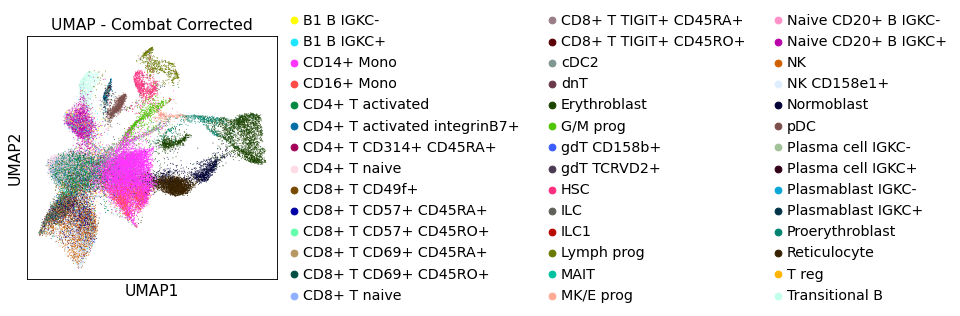

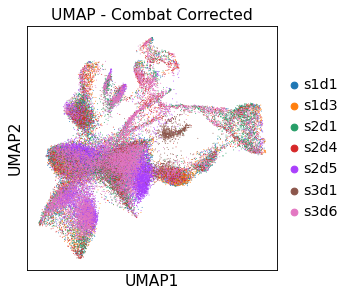

In [11]:
sc.pp.highly_variable_genes(adata_gex, n_top_genes=2500)
input_mod1 = adata_gex[:,adata_gex.var.highly_variable].copy()
sc.pp.combat(input_mod1)

sc.pp.highly_variable_genes(input_mod1)
input_mod1 = input_mod1[:,input_mod1.var.highly_variable]
sc.pp.scale(input_mod1, max_value=10)
sc.tl.pca(input_mod1, svd_solver='arpack')
sc.pp.neighbors(input_mod1, n_pcs = 50, n_neighbors = 20)
sc.tl.umap(input_mod1)

#UMAP with Combat batch correction and all genes
sc.set_figure_params(scanpy=True, dpi=80)
sc.pl.umap(input_mod1, color="cell_type", title="UMAP - Combat Corrected", show=True) #, legend_loc='on data')
sc.pl.umap(input_mod1, color="batch", title="UMAP - Combat Corrected", show=True)


In [4]:
#--------------------------------------------------------------------
# This takes time, but saves more time during training
#--------------------------------------------------------------------
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import dijkstra
import time

start_time = time.time()
dist_matrix = dijkstra(csgraph=input_mod1.obsp['connectivities'], directed=False, return_predecessors=False)
print("--- %s seconds ---" % (time.time() - start_time))


--- 3419.9416818618774 seconds ---


In [5]:
np.all(input_mod1.obs_names == adata_gex.obs_names)

True

In [6]:
adata_gex.obsp['distance'] = dist_matrix

In [11]:
# This is the final data for GEX
adata_gex.write('data/Cite_GEX.training.h5ad')
